<a href="https://colab.research.google.com/github/jiminmini/mini/blob/main/%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**전처리**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
sub_df=pd.read_csv('sample_submission.csv')
test_df=pd.read_csv('test.csv')
train_df=pd.read_csv('train.csv')

In [3]:
# 📌 결측값 확인
print(train_df.isnull().sum())

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64


In [4]:
# 📌 와인 종류 인코딩
train_df['type'] = train_df['type'].map({'white': 0, 'red': 1})
test_df['type'] = test_df['type'].map({'white': 0, 'red': 1})

#📌 alcohol: 연속 등분
train_df['alcohol_bin'] = pd.cut(train_df['alcohol'], bins=3, labels=['low', 'medium', 'high'])
test_df['alcohol_bin'] = pd.cut(test_df['alcohol'], bins=3, labels=['low', 'medium', 'high'])

#📌 volatile acidity: 분위수 기준
train_df['volatile_acidity_bin'] = pd.qcut(train_df['volatile acidity'], q=3, labels=['high', 'medium', 'low'])
test_df['volatile_acidity_bin'] = pd.qcut(test_df['volatile acidity'], q=3, labels=['high', 'medium', 'low'])

In [5]:
# 사용할 feature와 target 지정
X = train_df.drop(columns=['quality'])
y = train_df['quality']

# 수치형/범주형 feature 나누기
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

# bin 컬럼 범주형 처
bin_cols = ['alcohol_bin', 'volatile_acidity_bin']
for col in bin_cols:
    X[col] = X[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    categorical_features.append(col)
    if col in numeric_features:
        numeric_features.remove(col)

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


#**분류 모델(Gradient Boosting)**

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
# 모델 정의
models = {
    'LGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# 학습 데이터와 테스트 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 및 예측
for model_name, model in models.items():
    print(f"\n==== {model_name} ====")
    # 파이프라인: 전처리 + 모델 학습
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])




==== LGBM ====

==== XGBoost ====

==== GradientBoosting ====


In [8]:
# 모델 학습
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['index', 'fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol', 'type']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['alcohol_bin',
                                                   'volatile_acidity_bin',
                                                   'alcohol_bin',
                                                   'volatile_acidity_bin'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [9]:
# 예측
y_pred = pipeline.predict(X_val)


acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.5509


일부 클래스(3,9)의 샘플 수가 적어서 전체 정확도는 낮게 나옴

In [10]:
# 성능 평가
print(f"Model: {model_name}")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print("-" * 50)

Model: GradientBoosting
Accuracy: 0.5509090909090909
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.20      0.11      0.15        35
           5       0.61      0.55      0.58       351
           6       0.55      0.69      0.61       493
           7       0.50      0.33      0.40       183
           8       0.70      0.21      0.32        34
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1100
   macro avg       0.37      0.27      0.29      1100
weighted avg       0.55      0.55      0.54      1100

--------------------------------------------------


In [12]:
# sample_submission에 넣고 저장
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Gradient Boosting 모델로 전체 학습 데이터로 재학습
final_model = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])
pipeline.fit(X, y)

# test 데이터에 대한 예측
submission_preds = pipeline.predict(test_df)

# sample_submission 형식에 맞춰 결과 저장
submission = pd.read_csv('sample_submission.csv')
submission['quality'] = submission_preds
submission.to_csv('oosting_submission.csv', index=False)

In [14]:
from google.colab import files
files.download('boosting_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**[시각화]**

각 변수 간의 상관 관계 시각화
-수치형 변수들 간의 상관 관계를 확인할 수 있는 히트맵을 활용하여, 변수들 간의 상관 관계 파악

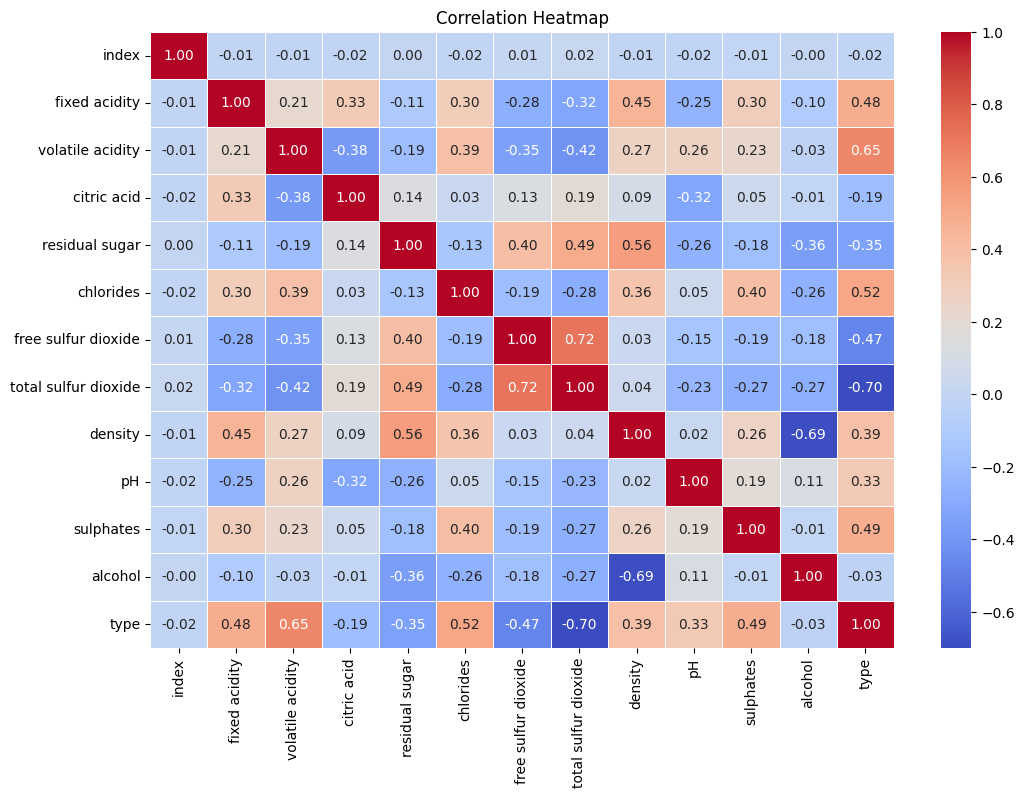

In [ ]:
correlation_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

+1: 완전한 양의 선형 관계 (A가 증가하면 B도 일정하게 증가)

0: 선형 관계 없음

-1: 완전한 음의 선형 관계 (A가 증가하면 B는 일정하게 감소)

